<a href="https://colab.research.google.com/github/viniciusvmda/procedural-texture/blob/master/gp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Programação Genética
https://www.pyimagesearch.com/2014/07/14/3-ways-compare-histograms-using-opencv-python/

## Requisitos

In [2]:
# GP
!pip install deap
# Graphics
!apt-get install graphviz libgraphviz-dev pkg-config
!pip install pygraphviz networkx
!pip install PIL
# Noise functions
!pip install noise

     |████████████████████████████████| 153kB 2.8MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
pkg-config is already the newest version (0.29.1-0ubuntu2).
graphviz is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libxdot4
0 upgraded, 8 newly installed, 0 to remove and 8 not upgraded.
Need to get 2,120 kB of archives.
After this operation, 7,128 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-common all 2.24.32-1ubunt

## Bibliotecas

In [0]:
# Genetic Programming
from deap import base, creator, gp, tools
# Graphics
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
from matplotlib import pyplot as plt
# Computer vision
import cv2
# Util
import numpy as np
import random
# Operators
from noise import pnoise2

## Desenvolvimento

### Gráficos

In [0]:
def plotTree(expr):
  nodes, edges, labels = gp.graph(expr)
  
  g = nx.DiGraph()
  g.add_nodes_from(nodes)
  g.add_edges_from(edges)
  pos = graphviz_layout(g, prog="dot")

  nx.draw_networkx_nodes(g, pos)
  nx.draw_networkx_edges(g, pos)
  nx.draw_networkx_labels(g, pos, labels)
  
  plt.show()
  
def plotImage(data):
  plt.axis("off")
  plt.imshow(data)
  plt.show()



### Algoritmo

#### Funções fitness

In [0]:
def getHistogram(img):
  hist = cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8],
		[0, 256, 0, 256, 0, 256])
	hist = cv2.normalize(hist, hist).flatten()
  return hist;


# Colour Direct Matching
def cdir(img1, img2):
  method = "Correlation"
  hist1 = getHistogram(img1)
  hist2 = getHistogram(img2)
  d = cv2.compareHist(index["doge.png"], hist, method)
  return d

#### Operadores

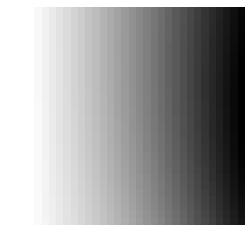

In [147]:
image = np.zeros((30, 30))

# persistence: [0,1]
def perlinNoise(image, scale, octaves, persistence, lacunarity):
  width = image.shape[0]
  height = image.shape[1]
  output = np.zeros((width, height))
  base = random.randint(1,100)
  for x in range(0, width):
    for y in range(0, height):
      output[x][y] = noise.pnoise2(x/scale, y/scale, octaves=octaves, persistence=persistence, 
                                    lacunarity=lacunarity, base=base)
  return output

out = perlinNoise(image, 100.0, 10, 0.4, 0.5)
plotImage(out)

#### Estrutura da árvore

In [0]:
# input e output => np.array 
pset = gp.PrimitiveSet("main", np.ndarray, np.ndarray)
pset.renameArguments(ARG0="input")
pset.addPrimitive(perlinNoise, np.ndarray, np.ndarray)


TypeError: ignored